# Basics of Quantum Neural Network Structure

In [136]:
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.algorithms.optimizers import L_BFGS_B
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
algorithm_globals.random_seed = 42
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

## Estimator QNN

Estimator QNN takes as input a parameterised circuit. To constructor a Estimator QNN first we need to construct a quantum circuit which will act as input.

Creating a quantum cicuit.

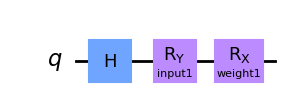

In [49]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")


We will now create a quantum observable in the form of Y*no_of_qbits of circuit.

In [50]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Estimator QNN takes the following input:

1. Quantum circuit - qc1 constructed in this case
2. Quantum observable - observable1 based on the Y*no_of_qbit
3. estimator - (optional) primitive instance
4. input_params - list of quantum circuit parameters that can be treated as network inputs.
5. weight_params - list of quantum circuit parameters that can be treated as weight parameter.


Lets create a Estimator QNN

In [51]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

## Sampler QNN

Sampler QNN is constructed in a similar way to Estimator QNN but it does not require a custom observable.

Lets create a Sampler QNN with 2 input parameters and 4 trainable weights.

In [121]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)




In [68]:
# Creating two qubit circuit
num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

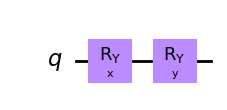

In [122]:
qc.draw("mpl")

In [123]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

In [124]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters,interpret=parity , output_shape=2)
sampler_qnn

## VQR Regression

In [137]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

## Linear Regression using SamplerQNN

In [138]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [176]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=sampler_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=30),
    callback=callback_graph,
)

### Sample Data

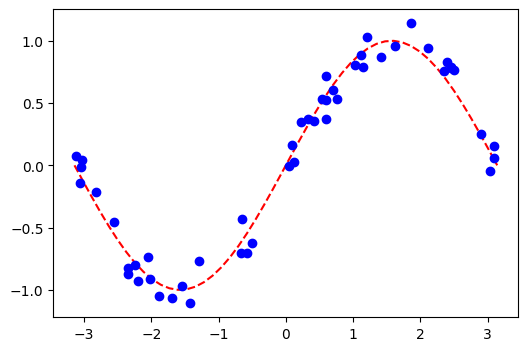

In [177]:
num_samples = 50
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x) 

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [178]:
y.reshape(-1,1).shape

(50, 1)

In [179]:
x_new = y.reshape(-1,1)

In [180]:
X.reshape(-1)

array([ 2.45056452,  0.58955472, -2.34974579, -2.23858167,  1.21325435,
       -2.05495385,  0.0458214 ,  3.08991016, -3.11641213, -3.03741869,
        3.0981418 ,  0.53180148, -2.34419376,  2.49632334,  2.38999991,
        0.2274539 ,  0.76524189, -1.42510691, -2.82416804,  0.59418581,
       -1.28959115,  1.02806136,  2.11269075, -3.02748659,  0.60138738,
       -1.68841416,  2.34921072, -1.54777155,  0.69598927,  0.33640702,
       -0.65240512,  1.11602417,  1.41855245,  0.42058257,  1.6237148 ,
        3.03739907, -0.50722655,  0.09162802, -3.0632421 ,  1.86000228,
        0.12710926, -0.57829539, -2.55052108,  2.4482835 , -0.65968897,
        1.14719402, -2.20304715,  2.90000185, -2.02041   , -1.88783334])

In [181]:
y_new = X.reshape(-1)

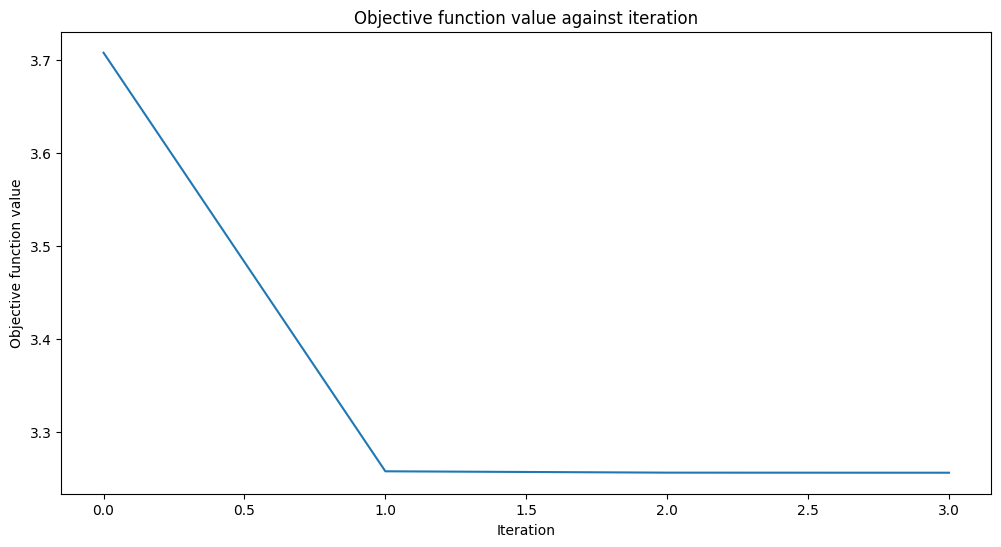

ValueError: y_true and y_pred have different number of output (1!=2)

In [182]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(x_new, y_new)

# # return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# # score the result
regressor.score(x_new, y_new)

In [183]:
y_pred = regressor.predict(x_new)

In [184]:
y_pred.shape

(50, 2)

In [185]:
y_pred

array([[3.45483614e-01, 6.54516386e-01],
       [3.74227145e-01, 6.25772855e-01],
       [9.80905035e-01, 1.90949645e-02],
       [9.76656277e-01, 2.33437234e-02],
       [2.32963549e-01, 7.67036451e-01],
       [9.66104318e-01, 3.38956824e-02],
       [7.26140241e-01, 2.73859759e-01],
       [6.98515552e-01, 3.01484448e-01],
       [6.92514099e-01, 3.07485901e-01],
       [7.30125693e-01, 2.69874307e-01],
       [6.52589240e-01, 3.47410760e-01],
       [4.65869911e-01, 5.34130089e-01],
       [9.86792834e-01, 1.32071656e-02],
       [3.54029385e-01, 6.45970615e-01],
       [3.22793978e-01, 6.77206022e-01],
       [5.60853936e-01, 4.39146064e-01],
       [4.67069160e-01, 5.32930840e-01],
       [9.99996764e-01, 3.23614351e-06],
       [8.14951302e-01, 1.85048698e-01],
       [5.48750796e-01, 4.51249204e-01],
       [9.72202291e-01, 2.77977085e-02],
       [3.33063145e-01, 6.66936855e-01],
       [2.70126144e-01, 7.29873856e-01],
       [7.06423306e-01, 2.93576694e-01],
       [4.715694